# Big Data course (a.y. 2020-21) Final Project

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats
import pyspark
import os

## Introduction

This project will focus on the analysis of the [MovieLens 1M dataset](https://grouplens.org/datasets/movielens/1m/). The dataset contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The dataset constitues of three DAT files:

- ```movies.dat```

- ```ratings.dat```

- ```users.dat```

##### ```movies.dat```

```movies.dat``` file stores movie information. Data are stored following this format:

**MovieID::Title::Genres**

Titles are identical to titles provided by the IMDB (including year of release).

Genres are pipe-separated and are selected from the following genres:

- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western

Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries

Movies are mostly entered by hand, so errors and inconsistencies may exist.

#### ```ratings.dat```

Ratings are contained in the file ```ratings.dat``` and are stored in the following format:

**UserID::MovieID::Rating::Timestamp**

- UserIDs range between 1 and 6040 

- MovieIDs range between 1 and 3952

- Ratings are made on a 5-star scale (whole-star ratings only)

- Timestamp is represented in seconds since the epoch as returned by ```time(2)```

- Each user has at least 20 ratings

#### ```users.dat```

User information are stored in  ```users.dat``` file. Data are stored with the following format:

**UserID::Gender::Age::Occupation::Zip-code**

All demographic information is provided voluntarily by the users and is not checked for accuracy.  Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female.

Age is chosen from the following ranges:

- 1:  "Under 18"
- 18:  "18-24"
- 25:  "25-34"
- 35:  "35-44"
- 45:  "45-49"
- 50:  "50-55"
- 56:  "56+"

The occupation is chosen from the following choices:

- 0:  "other" or not specified
- 1:  "academic/educator"
- 2:  "artist"
- 3:  "clerical/admin"
- 4:  "college/grad student"
- 5:  "customer service"
- 6:  "doctor/health care"
- 7:  "executive/managerial"
- 8:  "farmer"
- 9:  "homemaker"
- 10:  "K-12 student"
- 11:  "lawyer"
- 12:  "programmer"
- 13:  "retired"
- 14:  "sales/marketing"
- 15:  "scientist"
- 16:  "self-employed"
- 17:  "technician/engineer"
- 18:  "tradesman/craftsman"
- 19:  "unemployed"
- 20:  "writer"

In [3]:
sc = pyspark.SparkContext(appName="mySparkApp")
movielens_dir = "../data/"

## Exploratory analysis

Load MovieLens data and print the first five values for each file.

In [5]:
movies_data = sc.textFile(os.path.join(movielens_dir, "movies.dat"))\
  .map(lambda x : x.split("::"))
ratings_data = sc.textFile(os.path.join(movielens_dir, "ratings.dat"))\
  .map(lambda x : x .split("::"))
users_data = sc.textFile(os.path.join(movielens_dir, "users.dat"))\
  .map(lambda x : x.split("::"))
print(movies_data.take(5), end="\n\n")
print(ratings_data.take(5), end="\n\n")
print(users_data.take(5))

[['1', 'Toy Story (1995)', "Animation|Children's|Comedy"], ['2', 'Jumanji (1995)', "Adventure|Children's|Fantasy"], ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance'], ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama'], ['5', 'Father of the Bride Part II (1995)', 'Comedy']]

[['1', '1193', '5', '978300760'], ['1', '661', '3', '978302109'], ['1', '914', '3', '978301968'], ['1', '3408', '4', '978300275'], ['1', '2355', '5', '978824291']]

[['1', 'F', '1', '10', '48067'], ['2', 'M', '56', '16', '70072'], ['3', 'M', '25', '15', '55117'], ['4', 'M', '45', '7', '02460'], ['5', 'M', '25', '20', '55455']]


Let's now compute the number of ratings for each movie.

We'll, then, plot the distribution of ratings per movie.

[(1, 2077), (2, 701), (3, 478), (4, 170), (5, 296)]


/Users/manuel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


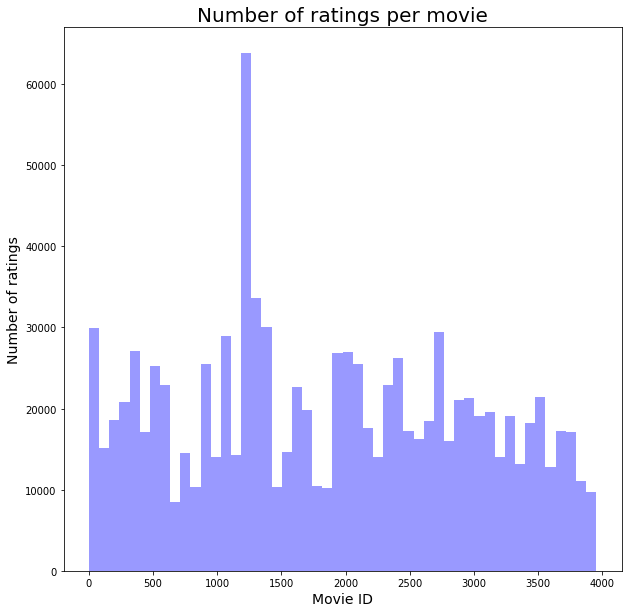

In [7]:
ratingByMovieCount = ratings_data.map(lambda x : (int(x[1]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .collect()
print(ratingByMovieCount[:5])

# plot distribution using histogram
ratings = []
for e in ratingByMovieCount:
  for _ in range(e[1]): ratings.append(e[0])
plt.figure(figsize=(10,10))
sns.distplot(ratings, kde=False, hist=True, color="blue")
plt.xlabel("Movie ID", size=14)
plt.ylabel("Number of ratings", size=14)
plt.title("Number of ratings per movie",size=20)
plt.show()


We can now retrieve how many movies each user rated.

We can then plot the number of ratings per user, as done before.

[(1, 53), (2, 129), (3, 51), (4, 21), (5, 198)]


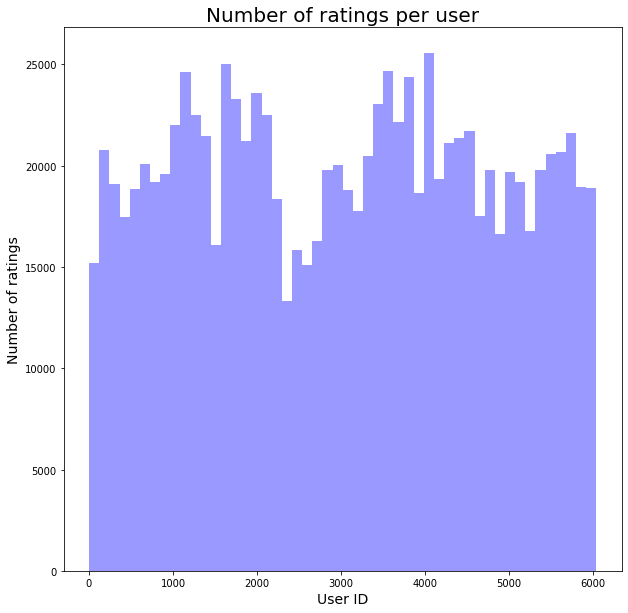

In [8]:
ratingsByUserCount = ratings_data.map(lambda x : (int(x[0]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .collect()
print(ratingsByUserCount[:5])

# plot distribution using histogram
ratings = []
for e in ratingsByUserCount:
  for _ in range(e[1]): ratings.append(e[0])
plt.figure(figsize=(10,10))
sns.distplot(ratings, kde=False, hist=True, color="blue")
plt.xlabel("User ID", size=14)
plt.ylabel("Number of ratings", size=14)
plt.title("Number of ratings per user",size=20)
plt.show()

Let's now recover the average rating score received by each movie in MovieLens dataset.

In [15]:
# take those movies with > 1 review
avgScoreByMovie = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 1)\
  .map(lambda x : (x[0], np.mean(x[1])))
print(avgScoreByMovie.takeOrdered(10, key = lambda x : -x[1]))  # sort in decreasing order

[(787, 5.0), (3233, 5.0), (3245, 4.8), (53, 4.75), (2503, 4.666666666666667), (2905, 4.608695652173913), (2019, 4.560509554140127), (318, 4.554557700942973), (858, 4.524966261808367), (745, 4.52054794520548)]


We can now recover the average rating score given by each user.

In [16]:
# take those users with > 1 review
avgScoreByUser = ratings_data.map(lambda x : (int(x[0]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 1)\
  .map(lambda x : (x[0], np.mean(x[1])))
print(avgScoreByUser.takeOrdered(10, key = lambda x : -x[1]))  # sort in decreasing order

[(283, 4.962962962962963), (2339, 4.956521739130435), (3324, 4.904761904761905), (3902, 4.890909090909091), (446, 4.8431372549019605), (447, 4.837837837837838), (4649, 4.818181818181818), (4634, 4.813725490196078), (1131, 4.796116504854369), (4925, 4.761904761904762)]


Let's now recover the top $K$ movies (e.g., $K = 10$) having at least $R$ ratings (e.g., $R > 20$), i.e., the $K$ movies with the highest average rating that have at least $R$ reviews.

In [17]:
top10Movies = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .filter(lambda x : len(x[1]) > 20)\
  .map(lambda x : (x[0], np.mean(x[1])))\
  .takeOrdered(10, key = lambda x : -x[1])
top10Movies = sc.parallelize(top10Movies)

# retrieve movies names
movies_names = movies_data.map(lambda x : (int(x[0]), x[1]))\
  .sortByKey()

top10MoviesNames = top10Movies.join(movies_names)\
  .map(lambda x : (x[1][1], x[1][0]))\
  .takeOrdered(10, key = lambda x : -x[1])
print(top10MoviesNames)

[('Sanjuro (1962)', 4.608695652173913), ('Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)', 4.560509554140127), ('Shawshank Redemption, The (1994)', 4.554557700942973), ('Godfather, The (1972)', 4.524966261808367), ('Close Shave, A (1995)', 4.52054794520548), ('Usual Suspects, The (1995)', 4.517106001121705), ("Schindler's List (1993)", 4.510416666666667), ('Wrong Trousers, The (1993)', 4.507936507936508), ('Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 4.491489361702127), ('Raiders of the Lost Ark (1981)', 4.477724741447892)]


## Complex queries on the dataset

**Q1** • Find if there is a correlation between the standard deviation of the ratings a movie has received, and
the number of ratings.

In [18]:
# recover movie ratings 
movieRatings = ratings_data.map(lambda x : (int(x[1]), [int(x[2])]))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()\
  .map(lambda x : (x[0], np.std(x[1])))

# recover number of ratings per movie
ratingNumber = ratings_data.map(lambda x : (int(x[1]), 1))\
  .reduceByKey(lambda a,b : a + b)\
  .sortByKey()

# new RDD with [std[rating[movie]], len(rating[movie])]
movieStdRatingCorr = movieRatings.join(ratingNumber)\
  .sortByKey()\
  .map(lambda x : (x[1][0], x[1][1]))\
  .collect()

# compute Pearson's correlation
stdevs = [e[0] for e in movieStdRatingCorr]
nrats = [e[1] for e in movieStdRatingCorr]
print(scipy.stats.pearsonr(stdevs, nrats))  # corr = 0.022 | P-val = 0.17  --> not correlated

(0.022378105407863134, 0.17319118659128352)
